In [11]:
import tables as tb
import pandas as pd
omadatalocation = '/data/databases/OMA/OMA.2.1.1/data/OmaServer.h5'



In [12]:
omadata = tb.open_file(omadatalocation)

In [13]:
print  dir(omadata.root.Ontologies.GO)





['_AttributeSet', '__class__', '__del__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__getitem__', '__hash__', '__init__', '__iter__', '__len__', '__module__', '__new__', '__next__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__unicode__', '__weakref__', '_append', '_c_classid', '_calc_chunkshape', '_calc_nrowsinbuf', '_check_shape', '_create_array', '_create_carray', '_f_close', '_f_copy', '_f_delattr', '_f_getattr', '_f_isvisible', '_f_move', '_f_remove', '_f_rename', '_f_setattr', '_fancy_selection', '_flavor', '_g_check_group', '_g_check_name', '_g_check_not_contains', '_g_check_open', '_g_close', '_g_copy', '_g_copy_as_child', '_g_copy_with_stats', '_g_create', '_g_create_common', '_g_del_location', '_g_delete', '_g_fix_byteorder_data', '_g_flush', '_g_getparent', '_g_gettitle', '_g_log_create', '_g_log_move', '_g_maybe_remove', '_g_move', '_g_new', '_g_open'

In [14]:
print(omadata.root.HogLevel.description)

Description([('Fam', '()i4'), ('ID', '()S255'), ('Level', '()S255')])


/usr/local/lib/python2.7/dist-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/ID/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


In [15]:
print(omadata.root.HogLevel[0:10])

[(299330, 'HOG:0299330', 'Chromadorea')
 (299330, 'HOG:0299330', 'Pristionchus pacificus')
 (299330, 'HOG:0299330', 'Onchocercidae')
 (299330, 'HOG:0299330', 'Brugia malayi')
 (299330, 'HOG:0299330', 'Loa loa')
 (299330, 'HOG:0299330', 'Onchocerca volvulus')
 (299330, 'HOG:0299330', 'Rhabditida')
 (299330, 'HOG:0299330', 'Strongyloides ratti')
 (299330, 'HOG:0299330', 'Caenorhabditis')
 (299330, 'HOG:0299330', 'Caenorhabditis brenneri')]


<h1> Using sets to count the unique occurences in each column</h1>

In [17]:
Taxa = set([])
Hogs = set([])
Fams = set([])
rows = 0

for row in omadata.root.HogLevel:
    Taxa.add(row[2])
    Hogs.add(row[1])
    Fams.add(row[0])
    rows+=1

print(len(Taxa))
print('taxa')
print(len(Hogs))
print('Hogs')
print(len(Fams))
print('Fams')
print(rows)
print('entries')
    

2920
taxa
2715332
Hogs
589223
Fams
17467463
entries


In [18]:
import pickle
    
handle1 = open('./hogs.pkl','w')
handle2= open('./fams.pkl','w')
handle3 = open('./taxa.pkl','w')

pickle.dump(Hogs,handle1,-1)
pickle.dump(Fams,handle2,-1)
pickle.dump(Taxa,handle3,-1)

handle1.close()
handle2.close()
handle3.close()

<h1> Create a dictionary for HOGs and families </h1> The taxonomy dict isn't really necesary since we have one from the other taxonomy notebook that will be more useful in selecting our reference taxa later.

In [9]:
#use the column dictionary from the taxonomic analysis here
import pickle
import numpy as np
handle1 = open('./TAXIDtoColumn.pkl', 'r')
handle2= open('./NameToID.pkl','r')

NameToID = pickle.load(handle2, )
column_dict = pickle.load(handle1)
handle1.close()
handle2.close()


handle1 = open('./hogs.pkl','r')
handle2= open('./fams.pkl','r')
handle3 = open('./taxa.pkl','r')

Hogs = pickle.load(handle1)
Fams = pickle.load(handle2)
Taxa = pickle.load(handle3)

handle1.close()
handle2.close()
handle3.close()


coldict={}
coldictReverse = {}

for i,taxon in enumerate(Taxa):
    coldict[taxon]=i
    coldictReverse[i] = taxon
rowdict={}
rowdictReverse={}
#define a row for each unique hog
for i,hog in enumerate(Hogs):
    rowdict[hog]= i
    rowdictReverse[i]=hog
rowdictFam ={}
rowdictFamReverse = {}
#define a row for each unique family
#dont know if we'll use this...
for i,fam in enumerate(Fams):
    rowdictFam[fam] = i
    rowdictFamReverse[i]=fam

colmax=max(column_dict.values())+1
rowmax=len(Hogs)+1

from scipy.sparse import lil_matrix

def retMatrixChunk( Hogdatachunk ):
    matrix = lil_matrix((rowmax,colmax))
    fams,hogs,taxa =Hogdatachunk
    matrix[ ([rowdict[hog] for hog in hogs] , [column_dict[NameToID [taxon]] for taxon in taxa] ) ] = 1
    return matrix


def retMatrixindex( Hogdatachunk ):
    fams,hogs,taxa =Hogdatachunk
    return ([rowdict[hog] for hog in hogs] , [column_dict[NameToID [taxon]] for taxon in taxa] ) 

def returnDataChunk( HogData , chunksize):
    i=0
    chunk =[]
    while len(chunk) > 0 or i == 0:
        try:
            chunk = HogData[i*chunksize:(i+1)*chunksize]
            fams,hogs,taxa = zip(*chunk)
            i +=1
            yield [fams, hogs, taxa]
        except:
            break

EOFError: 

Just testing out the generator and the transformation to sparse matrix format. 

In [6]:
import time


it = returnDataChunk(omadata.root.HogLevel,1000)
for x in range(10):
    start = time.clock()

    retMatrixindex(next(it))

    print(str( time.clock()-start ))



0.003838
0.002741
0.008794
0.002528
0.008558
0.002469
0.008058
0.002418
0.008098
0.002436


<h1>Transform taxonomic levels in OMA to sparse matrix</h1>
To avoid passing vars around we'll use queues to pass chunks of OMA and return chunks of the final matrix.

Each taxonomic level corresponds to a column and each row corresponds to a HOG. This takes an hour or two to calculate for all Hogs. 

In [7]:
#return datachunks to MP function
chunksize = 10000
import multiprocessing as mp
import threading
import time
import gc
import sys 
import redis


datagenerator = returnDataChunk(omadata.root.HogLevel, chunksize ) 

def worker(q,retq,l):
    while True:
        data = q.get()
        if data == 'DONE':
            break
        indices = retMatrixindex(data)
        retq.put(indices)
        del data
        gc.collect()  

def updater(q,retq,l):
    cooevolution_matrix = lil_matrix( (rowmax,colmax) )
    while True:
        indices = retq.get()
        if indices == 'DONE':
            break
        cooevolution_matrix[indices] = 1
        del indices
        gc.collect()   
    q.put(cooevolution_matrix)
l = mp.Lock()
cores = mp.cpu_count()
q = mp.Queue(maxsize = 2*cores-1)
retq = mp.Queue(maxsize = 2*cores)
processes =[]
for i in range(cores*2):
    t = mp.Process(target=worker, args=(q,retq,l)  ) 
    t.daemon = True
    t.start()
    processes.append(t)

u = mp.Process(target=updater, args=(q,retq,l)  ) 
u.daemon = True
u.start()

count =0
start = 0
data = next(datagenerator)
q.put(data)
start = time.clock()


while True:
    time.sleep(.01)
    try:
        data = next(datagenerator)
        q.put(data)
        count += chunksize
        if count % (10*chunksize) == 0:
            print count
    except StopIteration:
        for p in range(len(processes)):
            q.put('DONE')
        break     
retq.put('DONE')

cooevolution_matrix = q.get()        
print 'DONE!!!!!'
#save the matrix
stop = time.clock()
print 'hours'
print (stop - start) / 3600
handle1=open('./BigCoEvMatrix.pkl' , 'w')
pickle.dump(cooevolution_matrix,handle1, -1)
handle1.close()




100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000
1

TypeError: unsupported operand type(s) for -: 'float' and 'builtin_function_or_method'

In [8]:
handle1=open('./BigCoEvMatrix.pkl' , 'w')
pickle.dump(cooevolution_matrix,handle1, -1)
handle1.close()

In [2]:


from scipy.sparse import find
import multiprocessing as mp
import time
import pickle

handle1 =open('./BigCoEvMatrix.pkl' , 'r')
cooevolution_matrix = pickle.load(handle1)
handle1.close()






In [13]:
from datasketch import MinHash, LeanMinHash , MinHashLSHForest, HyperLogLogPlusPlus
import numpy as np
import gc

def returnHashes(data, verbose= False):
    rowstart, rowend , dataChunk = data
    indices = np.vstack( find( dataChunk )).astype(np.int).T
    if verbose == True:
        print indices 
    hashes ={}
    #update hashes with presence in species
    for row in range(indices.shape[0]):
        if rowstart+indices[row,0] not in hashes:
            hashes[rowstart+indices[row,0]] = MinHash(num_perm=100)
            if verbose == True:
                print 'row '+str(rowstart+indices[row,0])
        hashes[rowstart+indices[row,0]].update(indices[row,1])
        if verbose == True:
            print indices[row,1]
    #turn to small hashes
    for key in hashes:
        hashes[key]=LeanMinHash(hashes[key])
    
    del dataChunk
    gc.collect()
    return hashes

def chopMatrix(bigMatrix,chunksize):
    i =0
    leftovers = bigMatrix.shape[0]%chunksize
    
    while i <  bigMatrix.shape[0] - leftovers :
        chunk = bigMatrix[i:i+chunksize,:]
        yield [i,i+chunksize,chunk]
        i+=chunksize
    yield [i,i+leftovers,bigMatrix[i:i+leftovers,:]]
    
    


<h1> test out the generator and Hashing functions </h1>
The generator chops a matrix into blocks of Nrows. The hashing function assigns hash to each HOG rownumber and updates it based on which columns are positive. When the updates are finished the hash is turned to a LeanMinHash with a smaller memory footprint


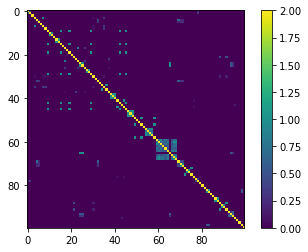

In [14]:
import time
from datasketch import MinHash, LeanMinHash , MinHashLSHForest, HyperLogLogPlusPlus
from matplotlib import pyplot as plt

data = next(chopMatrix(cooevolution_matrix,100))
start = time.clock()
hashes  = returnHashes(data, verbose= False)

dist = np.zeros((len(hashes), len(hashes)))
for i in range(len(hashes)):
    for j in range(len(hashes)):
        if i <=j:
            keyi = hashes.keys()[i]
            keyj = hashes.keys()[j]
            dist[i,j]= hashes[keyi].jaccard(hashes[keyj])

dist += dist.T

plt.imshow(dist)
plt.colorbar()
plt.show()


In [17]:
print len(hashes)
forest = MinHashLSHForest( num_perm=100 )
for key in hashes:
    forest.add(  key , hashes[key] )
print (hashes.keys()[0] in forest)
forest.index()
result = forest.query(hashes[hashes.keys()[0]],10)
print result

100
True
[0, 1, 78]


<h1>  calculate a hash for each HOG</h1> the same multiprocessing strategy as before expcept an updater process has the LSFforest and adds the hashes as they are calculated instead of using the main loop in the notebook. The end result is a dictionary of Hashes for each Hog and an LSF forest that includes all the Hashes and is searchable with a hash.


The top N neighbors for each HOG can be used as a threshold to avoid calculating other more costly distance metrics for all the HOGs vs all the HOGs.



In [19]:
from datasketch import MinHash, LeanMinHash , MinHashLSHForest, HyperLogLogPlusPlus
import multiprocessing as mp
import gc
import numpy as np
import redis

#use min hashing to generate a hash for each HOG and an LSH forest with all hashes
#use the jackard distance with LSH forest to grab top N hits for each HOG-> use as threshhold for distance matrices
#works with redis to store hash values

def worker(q,retque,l):
    while True:
        time.sleep(.01)
        data = q.get()
        if data == 'DONE':
            break
        obj = returnHashes(data)
        print 'done hashing'
        retq.put(obj)
        del obj
        del data
        gc.collect()
       
def updater(r,q,retq,l):
    i=0
    while True:
        data = retq.get()
        if data == 'DONE':
            break
        for key in data:
            r.set(key, pickle.dumps(data[key]))
        i +=1
        print 'update done'
        del data
        gc.collect()

chunksize = 10000
l = mp.Lock()
cores = mp.cpu_count()
q = mp.Queue(maxsize = cores/4)
retq = mp.Queue(maxsize = cores/4)
iterator = chopMatrix(cooevolution_matrix,chunksize)
r = redis.StrictRedis(host='localhost', port=6379, db=0)


processes =[]
for i in range(cores/4):
    t = mp.Process(target=worker, args=(q,retq,l)  ) 
    t.daemon = True
    t.start()
    u = mp.Process(target=updater, args=(r,q,retq,l)  ) 
    u.daemon = True
    u.start()
    processes.append(t)
    processes.append(u)
    count =0
while q.empty()==False or count == 0:
    time.sleep(.1)
    while True:
        count += 1
        try:
            data = next(iterator)
            print data
            q.put(data)
        except StopIteration:
            break

for p in processes:
    q.put('DONE')
q.close()
retq.close()

print 'DONE!!!!!'


[0, 10000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 61865 stored elements in LInked List format>]
[10000, 20000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62495 stored elements in LInked List format>]
[20000, 30000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 66082 stored elements in LInked List format>]
[30000, 40000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62334 stored elements in LInked List format>]
[40000, 50000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62752 stored elements in LInked List format>]
[50000, 60000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 67482 stored elements in LInked List format>]
[60000, 70000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 68744 stored elements in LInked List format>]
[70000, 80000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 59787 stored elements in LInked List forma

update done
update done
done hashing
[560000, 570000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 63382 stored elements in LInked List format>]
update done
done hashing
[570000, 580000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62658 stored elements in LInked List format>]
done hashing
[580000, 590000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 65787 stored elements in LInked List format>]
done hashing
update done
[590000, 600000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 69767 stored elements in LInked List format>]
update done
done hashing
update done
[600000, 610000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62773 stored elements in LInked List format>]
update done
done hashing
[610000, 620000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 65800 stored elements in LInked List format>]
done hashing
[620000, 630000, <10000x4167 sparse matrix of type '<type

[1100000, 1110000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 59284 stored elements in LInked List format>]
done hashing
update done
[1110000, 1120000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 65820 stored elements in LInked List format>]
update done
update done
done hashing
[1120000, 1130000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 61006 stored elements in LInked List format>]
update done
done hashing
done hashing
[1130000, 1140000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 63881 stored elements in LInked List format>]
[1140000, 1150000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 65045 stored elements in LInked List format>]
done hashing
[1150000, 1160000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 63420 stored elements in LInked List format>]
update done
update done
update done
done hashing
[1160000, 1170000, <10000x4167 sparse matrix of type '<typ

update done
update done
[1630000, 1640000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 64803 stored elements in LInked List format>]
done hashing
update done
[1640000, 1650000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 70815 stored elements in LInked List format>]
update done
done hashing
done hashing
[1650000, 1660000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 63661 stored elements in LInked List format>]
[1660000, 1670000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 64960 stored elements in LInked List format>]
update done
done hashing
update done
[1670000, 1680000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62463 stored elements in LInked List format>]
done hashing
update done
[1680000, 1690000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 64431 stored elements in LInked List format>]
update done
done hashing
done hashing
[1690000, 1700000, <10000x4167 sp

[2160000, 2170000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 60080 stored elements in LInked List format>]
update done
update done
done hashing
done hashing
[2170000, 2180000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 63793 stored elements in LInked List format>]
[2180000, 2190000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 65690 stored elements in LInked List format>]
update done
update done
done hashing
done hashing
[2190000, 2200000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 68445 stored elements in LInked List format>]
[2200000, 2210000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 60439 stored elements in LInked List format>]
update done
update done
done hashing
done hashing
[2210000, 2220000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62604 stored elements in LInked List format>]
[2220000, 2230000, <10000x4167 sparse matrix of type '<type 'numpy.flo

update done
done hashing
done hashing
[2690000, 2700000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62899 stored elements in LInked List format>]
[2700000, 2710000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 65112 stored elements in LInked List format>]
update done
done hashing
update done
[2710000, 2715333, <5333x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 37073 stored elements in LInked List format>]
done hashing
update done
update done
done hashing
done hashing
update done
done hashing
update done
done hashing
update done
update done
done hashing
done hashing
done hashing
update done
done hashing
update done
update done
DONE!!!!!
update done


In [9]:
import redis
import pickle
from nearpy.hashes import RandomBinaryProjections
from nearpy.storage import RedisStorage
from scipy.sparse import find

handle1=open('./BigCoEvMatrix.pkl' , 'r')
cooevolution_matrix = pickle.load(handle1)
handle1.close()



0


ValueError: dimension mismatch

In [4]:
#build the forest

import redis 
from datasketch import MinHash, LeanMinHash , MinHashLSHForest, HyperLogLogPlusPlus
r = redis.StrictRedis(host='localhost', port=6379, db=0)
forest = MinHashLSHForest(num_perm=100)
iterator = r.scan_iter()
for i,key in enumerate(iterator):
    hashval = pickle.loads(r.get(key))
    forest.add(key, hashval)
forest.index()

with open( './ForestALL.pkl', 'w') as forestfile:
    pickle.dump(forest, forestfile, -1)

    


In [7]:
import pickle
with open( './ForestALL.pkl', 'r') as forestfile:
    forest = pickle.load(forestfile)
 

In [19]:
from matplotlib import pyplot as plt
import redis
r = redis.StrictRedis(host='localhost', port=6379, db=0)

#hap2 HOG:0385024
hog = 'HOG:0385024'

hashval = pickle.loads(r.get(rowdict[hog]))
result = forest.query(  hashval , 200 )
resultHogs= np.asarray([rowdictReverse[int(row)] for row in result ]+[hog])
hashes = []
hashes.append(hashval)
for hog in result:
    hashval = pickle.loads(r.get(hog))
    hashes.append(hashval)
dist = np.zeros((len(hashes), len(hashes)))
for i in range(len(hashes)):
    for j in range(len(hashes)):
        if i <=j:
            dist[i,j]= hashes[i].jaccard(hashes[j])

            
clustering = np.argsort(dist[0,:])
dist = dist[clustering,:]
dist = dist[:,clustering]
resultHogs = resultHogs[clustering]
dist += dist.T
print Hogs
plt.imshow(dist)
plt.colorbar()
plt.show()


#gex1 HOG:0374514
hog = 'HOG:0374514'
hashval = pickle.loads(r.get(rowdict[hog]))
result = forest.query(hashval, 200 )

resultHogs= np.asarray([rowdictReverse[int(row)] for row in result ] +[hog])

hashes = []
hashes.append(hashval)
for hog in result:
    hashval = pickle.loads(r.get(hog))
    hashes.append(hashval)
dist = np.zeros((len(hashes), len(hashes)))
for i in range(len(hashes)):
    for j in range(len(hashes)):
        if i <=j:
            dist[i,j]= hashes[i].jaccard(hashes[j])

dist += dist.T

clustering = np.argsort(dist[0,:])[::-1]
print clustering
dist = dist[clustering,:]
dist = dist[:,clustering]
resultHogs = resultHogs[clustering]



print Hogs

plt.imshow(dist)
plt.colorbar()
plt.show()



NameError: name 'rowdict' is not defined

In [5]:
# use rest api to get HOG info


import requests
from requests.auth import HTTPDigestAuth
import  json
import pandas as pd
import pickle
"""
with open('/embeddings3d.pkl' , 'r') as projhandle:
    proj = pickle.load(projhandle)
with open('/IDtoRow.pkl' , 'r') as IDhandle:
    IDtoRow = pickle.load(IDHandle)
with open('/RowtoID.pkl' , 'r') as rowhandle:
    RowtoID = pickle.load(rowhandle)
"""
hogname = list(resultHogs)[0]
results = {}
for hogname in list(resultHogs):
    url = 'http://omabrowser.org/api/hog/'+hogname.replace(':', '%3A')+'/'
    results[hogname]= json.loads(requests.get(url).text)

    #map names to taxid
    #map taxid to row

print results

    
    

#get phylo signature on species tree

#get phylo signature sparse mat







NameError: name 'resultHogs' is not defined

In [ ]:
#get go term enrichment for results




In [ ]:
import pickle
import time 
import redis 

r = redis.StrictRedis(host='localhost', port=6379, db=0)
# test out the forest search for similar profiles
iterator = r.scan_iter()
import networkx as nx
Coevolution_1stpass = nx.Graph()

for i,key in enumerate(iterator):
    hashval = pickle.loads(r.get(key))
    #get 100 neighbors... prob enough to get all interators
    result = forest.query(hashval , 100)
    if i % 10000 == 0 :
        print str(i) + 'HOGS'
        print 'edges'
        print Coevolution_1stpass.number_of_edges()
        print 'nodes'
        print Coevolution_1stpass.number_of_nodes()
    #print result
    #compute jaccard dist for all neighbors
    #could parallelize this
    Coevolution_1stpass.add_node(key)
    for interactor in result:
        Coevolution_1stpass.add_node(interactor)
        j = hashval.jaccard( pickle.loads(r.get(interactor)) )
        Coevolution_1stpass.add_edge( key , interactor , jaccard = j )
        #generate a graph of HOG interaction iteratively
        #this could be useful to compare with PPIs
        #or as an object to use for searching for interactors
with open('graphobj.pkl' , 'w') as graphhandle:
    pickle.dump(Coevolution_1stpass , graphhandle , -1)
print 'DONE!'

    

0HOGS
edges
0
nodes
0
10000HOGS
edges
1927530
nodes
811135
20000HOGS
edges
3768947
nodes
1093266
30000HOGS
edges
5588484
nodes
1233803
40000HOGS
edges
7415393
nodes
1313348
50000HOGS
edges
9234902
nodes
1359744
60000HOGS
edges
11022273
nodes
1386350
70000HOGS
edges
12804420
nodes
1405116
80000HOGS
edges
14576268
nodes
1419049
90000HOGS
edges
16358379
nodes
1430038
100000HOGS
edges
18122481
nodes
1438553
110000HOGS
edges
19879233
nodes
1445657
120000HOGS
edges
21624600
nodes
1451372
130000HOGS
edges
23350223
nodes
1456248
140000HOGS
edges
25071721
nodes
1460521


edges
100
nodes
85
components
4


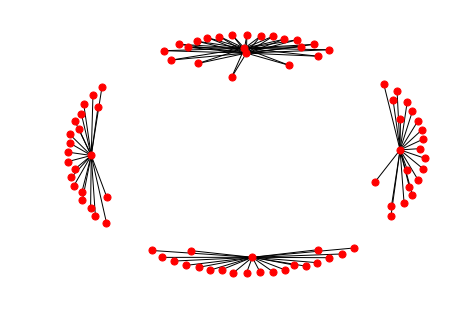

In [41]:
import pickle
import time 
import redis 
import networkx as nx
from matplotlib import pyplot as plt

r = redis.StrictRedis(host='localhost', port=6379, db=0)
plt.clf()

# test out the forest search for similar profiles
iterator = r.scan_iter()
subgraph = nx.Graph()

for i in range(5):
    key = next(iterator)
    hashval = pickle.loads(r.get(key))
    result = forest.query(hashval , 20)    
    subgraph.add_node(key)
    for interactor in result:
        subgraph.add_node(interactor )
        j = hashval.jaccard( pickle.loads(r.get(interactor)) )
        subgraph.add_edge( key , interactor , jaccard = j )

print 'edges'
print subgraph.number_of_edges()
print 'nodes'
print subgraph.number_of_nodes()
print 'components'
print nx.number_connected_components(subgraph)
    

nx.draw(subgraph , node_size = 50)

plt.show()

In [ ]:
#parallel implimentation of graph construction
import multiprocessing as mp
import redis 
import networkx as nx
import gc
import pickle

print 'loading forest'

with open( './ForestALL.pkl', 'r') as forestfile:
    forest = pickle.load(forestfile)
print 'forest loaded'

def worker(q,retq,l,forest, r ):
    while True:
        #make a sugraph for a HOG
        key= q.get()
        if key == 'DONE':
            break
        hashvalkey = pickle.loads(r.get(key))
        l.acquire()
        result = forest.query(hashvalkey,30)
        l.release()
        CoevolutionSubGraph = nx.Graph()
        CoevolutionSubGraph.add_node(key )
        for interactor in result:
            hashvalinteractor = pickle.loads(r.get(interactor))
            CoevolutionSubGraph.add_node(interactor)
            CoevolutionSubGraph.add_edge(key, interactor , jaccard = hashvalkey.jaccard(hashvalinteractor))
        retq.put(CoevolutionSubGraph)
        del CoevolutionSubGraph
        gc.collect()

def updater(q,retq,l ):
    #merge subgraphs
    G = nx.Graph()
    while True:
        subgraph = retq.get()
        if subgraph == 'DONE':
            break
        #union graphs
        G = nx.compose(G,subgraph)
        del subgraph
        gc.collect()
    q.put(G)

lock = mp.Lock()
r = redis.StrictRedis(host='localhost', port=6379, db=0)
iterator = r.scan_iter()
cores = mp.cpu_count()
q = mp.Queue(maxsize=1000)
retq = mp.Queue(maxsize=1000)
processes =[]

for i in range(cores):
    t = mp.Process(target=worker, args=(q,retq,lock ,forest,r)  ) 
    t.daemon = True
    t.start()
    processes.append(t)
u = mp.Process(target=updater, args=(q,retq,lock)  ) 
u.daemon = True
u.start()

for i,data in enumerate(iterator):
    if i % 100000 == 0 :
        print i
    q.put(data)
    
for p in processes:
    q.put('DONE')
retq.put('DONE')
finalgraph = q.get()

with open('graphobj.pkl' , 'w') as graphhandle:
    pickle.dump(Coevolution_1stpass , graphhandle , -1)
    
q.close()
retq.close()

print 'DONE!!!!!'

loading forest
forest loaded
0
100000


In [ ]:
#generate other distance metrics within clusters defined by the jaccard distance cutoff
#get the rows of the matrix from the network neighborhood...
#only calculate edges that don't have metric.
#reassign values to the edges.




#calculate the prob of 0 or the prob of 1 for each row
def prob_x_y_forBinary_M(two_rows):
    px_one = np.sum(two_rows[0,:])/two_rows.shape[1]
    px_zero = 1-px_one
    py_one = np.sum(two_rows[1,:])/two_rows.shape[1]
    py_zero = 1-py_one
    return np.array( [px_zero, px_one]), np.array([py_zero, py_one])

def pxy_coocurrence_between_two_M(m):
    #4 cases for two binary vectors. (x=1,y=1), (x=0,y=1), (x=1,y=0), (x=0,y=0) 
    #use matrix multiplication to get cooccurences between rows for all cases
    pxy_case1 = tf.multiply(m,m.T)/m.shape[1]
    pxy_case2 = tf.multiply(1-m, m.T )/m.shape[1]
    pxy_case3 = tf.multiply(m, 1-m.T)/m.shape[1]
    pxy_case4 =1 -tf.add([pxy_case1, pxy_case2 , pxy_case3])
    #Ncase 4 is whatever is leftover
    return pxy_case1, pxy_case2,pxy_case3, pxy_case4

def MI(probx,proby, cooccurenceMat ):
    #calculate MI of two rows
    px,py = prob_x_y(two_rows)
    pxy = pxy_coocurrence_between_two_rows(two_rows)
    MI=0
    for x in [0,1]:
        for y in [0,1]:
                MI+= pxy[x,y]*np.log( pxy[x,y] / (px[x] * py[y]) ) 
    return MI

def replacementMetric(probx,proby, cooccurenceMat ):
    #calculate only half the MI. when one prot replaces another
    #don't know if this will be useful..
    
    px,py = prob_x_y(two_rows)
    pxy = pxy_coocurrence_between_two_rows(two_rows)
    MI=0
    for x in [0,1]:
        MI+= pxy[x,1-x]*np.log( pxy[x,1-x] / (px[x] * py[1-x]) ) 
    return MI

def Hamming_dist(cooccurenceMats):
    return coocurrenceMats[1]*coocurrenceMats[1].shape[1]+cooccurenceMats[2]*coocurrenceMats[1].shape[1]


In [ ]:
#merge hogs function -> grab subhogs and merge hashes
def mergeHogs()
    
results = pool.map( )    



In [ ]:
#run PCA on subset of the data to filter out overrepresented species and project reduced matrix down to species subspace



handle1 =open('./BigCoEvMatrix.pkl' , 'r')
cooevolution_matrix = pickle.load(handle1)
handle1.close()


handle1 = open('./hogs.pkl','r')
handle2= open('./fams.pkl','r')
handle3 = open('./taxa.pkl','r')

Hogs = pickle.load(handle1)
Fams = pickle.load(handle2)
Taxa = pickle.load(handle3)

handle1.close()
handle2.close()
handle3.close()



#manifold is consistent across all hogs? Use random subsample for PCA








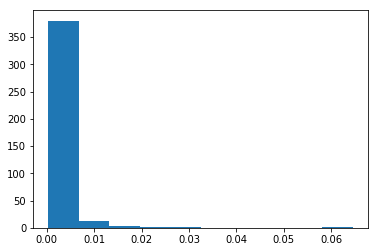

In [16]:
from sklearn.decomposition import TruncatedSVD as svd
import pickle
from matplotlib import pyplot as plt
randHogs = np.random.randint(0,len(Hogs), 10000)
submatrix = cooevolution_matrix[randHogs,:]
SVD = svd(n_components=400)
SVD.fit(submatrix)
plt.hist(SVD.explained_variance_ratio_.T)
plt.show()




In [17]:
print np.sum(SVD.explained_variance_ratio_.T)
print 'variance w/' + str(SVD.n_components) + ' components'



0.840992043543
variance w/400 components


In [ ]:
subT = SVD.transform(submatrix)

from sklearn.manifold import MDS
mds = MDS(n_jobs=-1)
pts = mds.fit_transform(subT)
plt.scatter( pts[:,0], pt[:,1])
plt.show()




In [ ]:

#zp2 hog is.
#HOG:0262715
